In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

## Loading Data

In [2]:
# Loading ssh_hf and making and selecting 1h for testing
ssh_hf = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_01.nc")
ssh_hf_1h = ssh_hf.rename({'__xarray_dataarray_variable__': 'ssh_hf'}).sel(time_counter=pd.to_datetime('2014-01-10T00:30:00')).load()

# Appying the mask to ssh_hf_1h, keep data where mask is equal to 1
mask = xr.open_dataset('/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc',drop_variables={"x","y"}) 
ssh_hf_1h_masked = ssh_hf_1h['ssh_hf'].where(mask.tmaskutil[0,:,:] == 1, np.nan).load()

## Changing Grid

In [3]:
# Set up UTM Zone 58S projection
proj = Proj(proj='utm', zone=58, south=True, ellps='WGS84')

# Get latitude and longitude data
lat = ssh_hf_1h.lat.values
lon = ssh_hf_1h.lon.values

# Transform lat, lon to UTM coordinates
x, y = np.vectorize(proj)(lon, lat)

# Convert coordinates from meters to kilometers
x_km = x / 1000
y_km = y / 1000

# Create a regular Cartesian grid with dx and dy = 1.7 km
dx, dy = 1.7, 1.7
x_min, x_max = x_km.min(), x_km.max()
y_min, y_max = y_km.min(), y_km.max()

# Define new grid
x_new = np.arange(x_min, x_max, dx)
y_new = np.arange(y_min, y_max, dy)
x_grid, y_grid = np.meshgrid(x_new, y_new)

# Interpolate to the new grid using 'nearest' for robust handling of NaNs
data_interp = griddata(
    (x_km.flatten(), y_km.flatten()),
    ssh_hf_1h_masked.values.flatten(),
    (x_grid, y_grid),
    method='nearest'
)

# Create new DataArray with the interpolated data on the regular grid
ssh_hf_1h_masked_regular = xr.DataArray(data_interp, coords=[('y', y_new), ('x', x_new)], dims=['y', 'x'])

In [5]:
ssh_hf_1h_masked_regular

<xarray.DataArray (y: 867, x: 829)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 7kB 6.791e+03 6.793e+03 ... 8.262e+03 8.264e+03
  * x        (x) float64 7kB -118.8 -117.1 -115.4 ... 1.287e+03 1.289e+03

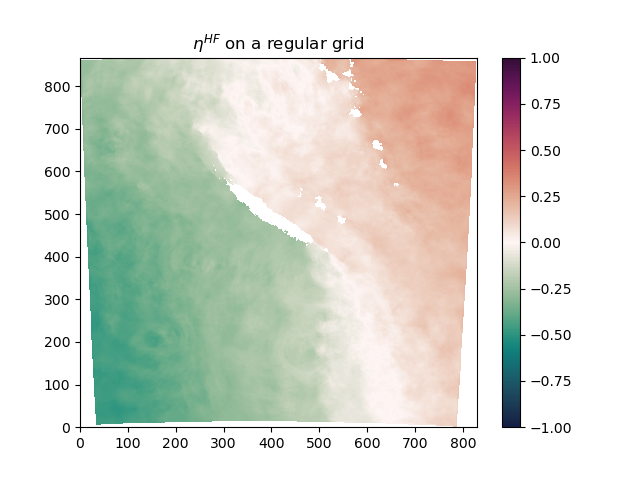

In [4]:
plt.figure()
plt.pcolormesh(ssh_hf_1h_masked_regular, cmap=cmocean.cm.curl, vmin=-1, vmax=1)
plt.colorbar()
plt.title('$\eta^{HF}$ on a regular grid')
plt.show()

## Filling NaNs

In [5]:
# Define the axes correctly using pyinterp.core.Axis
x_axis = pyinterp.core.Axis(ssh_hf_1h_masked_regular.x.values, is_circle=True)
y_axis = pyinterp.core.Axis(ssh_hf_1h_masked_regular.y.values, is_circle=True)
# Prepare the grid using pyinterp.Grid2D
grid = pyinterp.Grid2D(y_axis, x_axis, ssh_hf_1h_masked_regular.values)

In [6]:
has_converged, ssh_hf_1h_masked_regular_filled = fill.gauss_seidel(grid,num_threads=16)

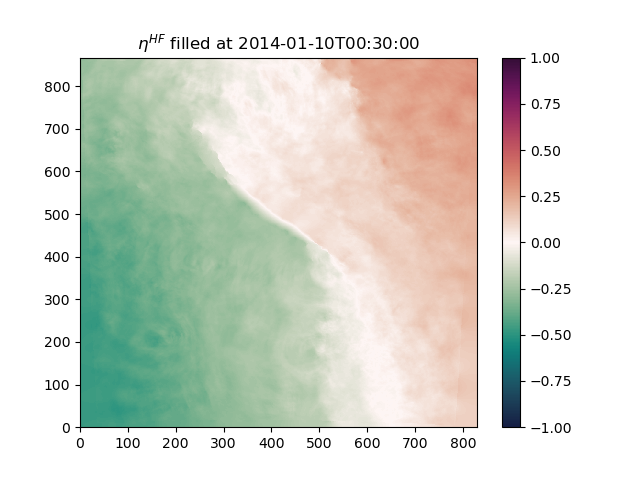

In [7]:
plt.figure()
plt.pcolormesh(ssh_hf_1h_masked_regular_filled, cmap=cmocean.cm.curl, vmin=-1, vmax=1)
plt.colorbar()
plt.title('$\eta^{HF}$ filled at 2014-01-10T00:30:00')
plt.show()

## Extract Barothropic Tide

### Paving

In [8]:
# Compute mean of dx and dy and convert to plain numbers # Ensure nx and ny are integers
nx = int(ssh_hf_1h_masked_regular_filled.shape[1]) 
ny = int(ssh_hf_1h_masked_regular_filled.shape[0])

In [9]:
def extend(ssh,nx,ny):
    ssh_extended = np.empty((3*ny,3*nx))
    ssh_extended[ny:2*ny,nx:2*nx] = +ssh
    ssh_extended[0:ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[2*ny:3*ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[:,0:nx] = ssh_extended[:,nx:2*nx][:,::-1]
    ssh_extended[:,2*nx:3*nx] = ssh_extended[:,nx:2*nx][:,::-1]
    return ssh_extended

In [10]:
ssh_hf_1h_masked_regular_filled_extended = extend(ssh_hf_1h_masked_regular_filled,nx,ny)

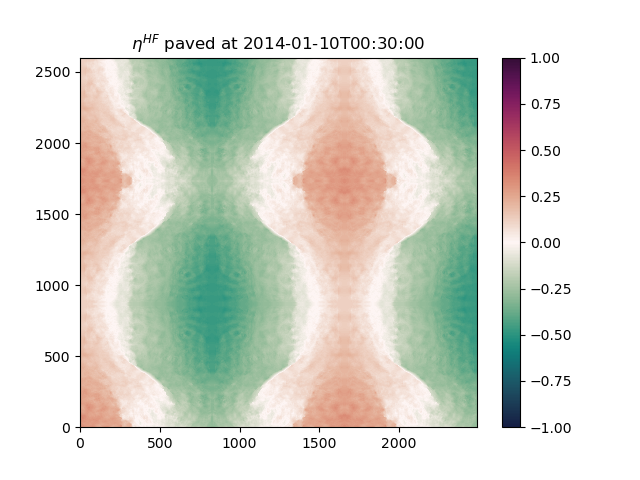

In [11]:
plt.figure()
plt.pcolormesh(ssh_hf_1h_masked_regular_filled_extended, cmap=cmocean.cm.curl, vmin=-1, vmax=1)
plt.colorbar()
plt.title('$\eta^{HF}$ paved at 2014-01-10T00:30:00')
plt.show()

### Wave Numbers

In [12]:
kx = np.fft.fftfreq(3*nx,dx) # km
ky = np.fft.fftfreq(3*ny,dy) # km
k, l = np.meshgrid(kx,ky)
wavenum2D = np.sqrt(k**2 + l**2) #is it ok?

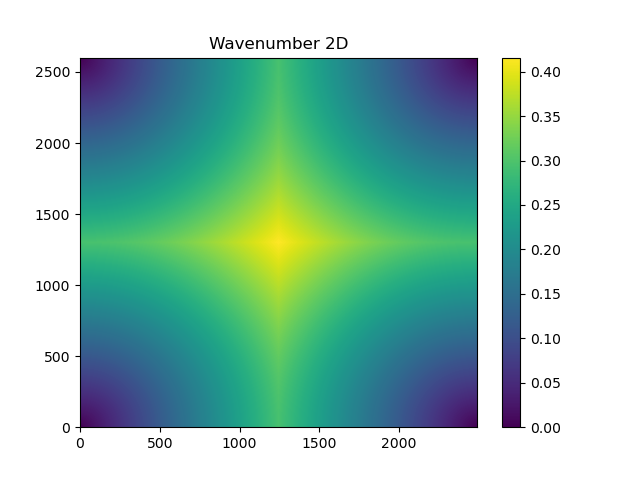

In [13]:
plt.figure()
plt.pcolormesh(wavenum2D)
plt.colorbar()
plt.title('Wavenumber 2D')
plt.show()

### Low Pass Filter

In [14]:
def lowpass(_lambda,nx,ny,wavenum2D) : 
    _lowpass = np.zeros((3*ny,3*nx))
    for i in range (3*ny):
        for j in range(3*nx):
            if wavenum2D[i,j]<1/_lambda:
                _lowpass[i,j] = 1
    return _lowpass 

### Gaspari Cohn

In [15]:
def gaspari_cohn(array,distance,center):
    if type(array) is float or type(array) is int:
        array = np.array([array])
    else:
        array = array
    if distance<=0:
        return np.zeros_like(array)
    else:
        array = 2*np.abs(array-center*np.ones_like(array))/distance
        gp = np.zeros_like(array)
        i= np.where(array<=1.)[0]
        gp[i]=-0.25*array[i]**5+0.5*array[i]**4+0.625*array[i]**3-5./3.*array[i]**2+1.
        i =np.where((array>1.)*(array<=2.))[0]
        gp[i] = 1./12.*array[i]**5-0.5*array[i]**4+0.625*array[i]**3+5./3.*array[i]**2-5.*array[i]+4.-2./3./array[i]
        #if type(r) is float:
        #    gp = gp[0]
    return gp

### Create Spatial Window

In [16]:
def create_spatial_window(nx,ny):
    result = np.ones((3*ny,3*nx))
    
    gaspari_x = np.expand_dims(gaspari_cohn(np.arange(2*nx),nx,nx),axis=0)
    gaspari_y = np.expand_dims(gaspari_cohn(np.arange(2*ny),ny,ny),axis=1)

    #paving edges with gaspari-cohn
    result[2*ny:,nx:2*nx] = np.repeat(gaspari_y[ny:,:],repeats=nx,axis=1)
    result[:ny,nx:2*nx] = np.repeat(gaspari_y[:ny,:],repeats=nx,axis=1)
    result[ny:2*ny,0:nx] = np.repeat(gaspari_x[:,:nx],repeats=ny,axis=0)
    result[ny:2*ny,2*nx:] = np.repeat(gaspari_x[:,nx:],repeats=ny,axis=0)

    #paving corners with gaspari-cohn
    result[2*ny:,2*nx:]=gaspari_y[ny:,:]*gaspari_x[:,nx:]
    result[:ny,:nx]=gaspari_y[:ny,:]*gaspari_x[:,:nx]
    result[2*ny:,:nx]=gaspari_y[ny:,:]*gaspari_x[:,:nx]
    result[:ny,2*nx:]=gaspari_y[:ny,:]*gaspari_x[:,nx:]

    return result 

In [17]:
window = create_spatial_window(nx,ny)

In [18]:
ssh_hf_1h_masked_regular_filled_extended_windowed = ssh_hf_1h_masked_regular_filled_extended * window

In [19]:
# plt.figure()
# plt.pcolormesh(ssh_hf_1h_masked_filled_extended_windowed, cmap=cmocean.cm.curl, vmin=-1, vmax=1)
# plt.colorbar()
# plt.title('$\eta^{HF}$ paved and windowed at 2014-01-10T00:30:00')
# plt.show()

### Filtering

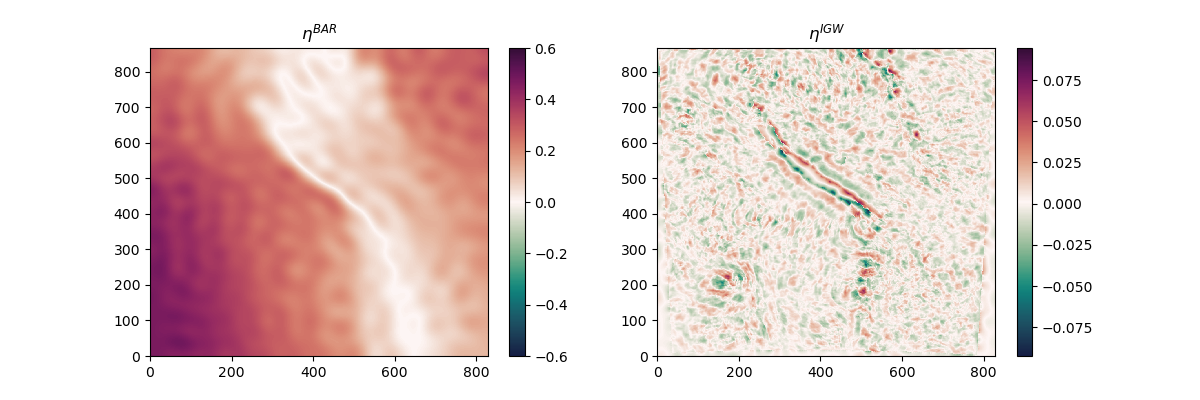

In [25]:
lambda_bar = 100
lowpass_bar = lowpass(lambda_bar, nx, ny, wavenum2D)

ssh_hf_freq = fp.fft2(ssh_hf_1h_masked_regular_filled_extended_windowed)
ssh_freq_filtered = lowpass_bar * ssh_hf_freq
ssh_bar = np.real(fp.ifft2(ssh_freq_filtered))[ny:2*ny, nx:2*nx]

ssh_igw = ssh_hf_1h_masked_regular_filled - ssh_bar

fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
im1 = axes[0].pcolormesh(np.abs(ssh_bar), cmap=cmocean.cm.curl
                         ,vmin=-0.6, vmax=0.6
                         )
fig.colorbar(im1, ax=axes[0])
axes[0].set_title('$\eta^{BAR}$')
im2 = axes[1].pcolormesh(ssh_igw, cmap=cmocean.cm.curl)
fig.colorbar(im2, ax=axes[1])
axes[1].set_title('$\eta^{IGW}$')
plt.show()